![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# Frost days analyses using Climate DT modeled data 2020-2040

Authors: Dr. Alen Berta (CGI), Cesare Rossi (CGI)

Licence: MIT

Reference:
https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide

Notes:
This example is intended for hands-on learning and does not constitute a comprehensive climatic study. This notebook will showcase the time series point analyses for 2 cities in Croatia (Zagreb as representative of continental climate and Dubrovnik as representative of Mediterranean climate). Service for analysing larger areas and exporting corresponding results in raster files will soon be available on Insula platform.


The data used here are based on SSP3 NEMO model, representing next to worst scenario modeled in Shared Socio-Economic Pathways (SSPs) predicting the highest population development and lowest GDP amongst the considered scenarios in the near future, with global mean temperature rising between 3.85 and 4.55 C until 2100. (more info and photo credit https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/)
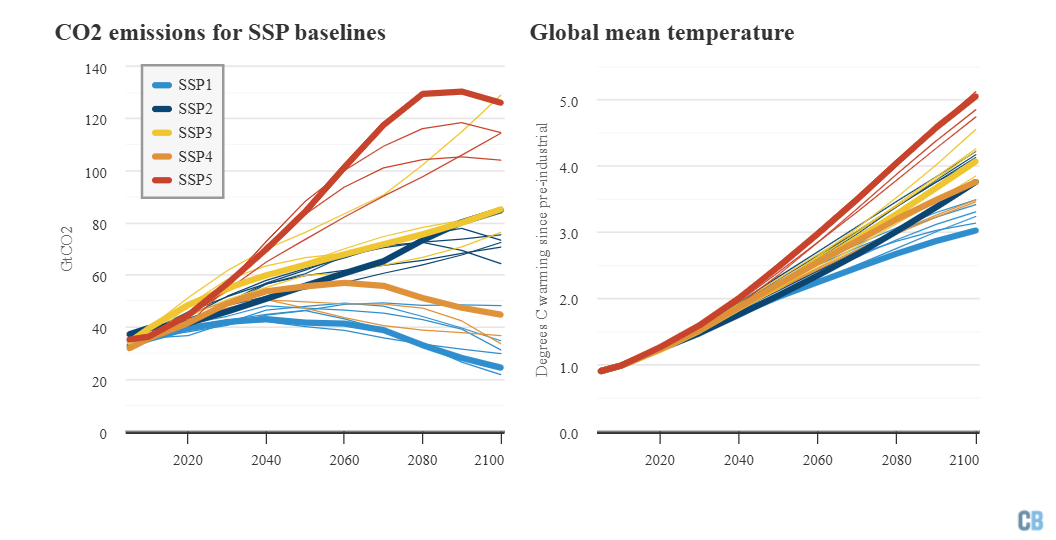

This notebook will provide the analyses relevant for detecting increased temperature stress due to climate change. The data used stem from Climate DT (https://destine.ecmwf.int/news/climate-change-adaptation-digital-twin-a-window-to-the-future-of-our-planet/) and will provide the calculation of some climate extreme indices (https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide).

Specifically we will present the approach to:
 1) Detect the number of frost days per month (nights when nightly minimum temperature is < 0 °C)
 2) Visualize the same index/indicator with the average values from 1990-2020 (extracted fromn ERA5) and 2021-2040 (extracted from the Climate DT)
 3) Visualize the standard deviation on monthly level concerning the averages from 1990-2020 and 2021-2040

## Data access

In [2]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Data loading

For this implementation, we wil focus on 2 metre temperature (t2m) data for the calculations.


In [3]:
import xarray as xr
import pandas as pd
import os
from utils import frost

In [4]:
data = xr.open_dataset(
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    storage_options={"client_kwargs":{"trust_env":"true"}},
    chunks={},
    engine="zarr",
)

In [5]:
data

<xarray.Dataset> Size: 800TB
Dimensions:           (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.96 90.0
  * longitude         (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
# Select needed variable from data lake
t2m = data.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"

In [7]:
zagreb_lat_lon=(45.8130,15.9772)
dubrovnik_lat_lon=(42.6491, 18.0940)

Select your year of interest between 2020 and 2040.

In [8]:
year_of_interest = "2035"

Decide whether you would like to perform a full analysis between 2020 and 2040.

In [9]:
full_2020_2040_analysis = False # If True, the analysis is performed against the whole period, then comparing it to the year_of_interest

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong> The computation time for one city/pixel/point for 2020-2040 might require 1.5 hours or more. Therefore, <b>for initial experiments, we suggest keeping the variable full_2020_2040_analysis set to False.</b>
</div>

In [10]:
# Select the data for Zagreb and Dubrovnik
t2m_zagreb = t2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')
t2m_dubrovnik = t2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')

if not full_2020_2040_analysis:
    # Subset the data for a given year
    t2m_zagreb = t2m_zagreb.sel(time=year_of_interest)
    t2m_dubrovnik = t2m_dubrovnik.sel(time=year_of_interest)

### Frost days analyses

The following cells will:

1) detect the minimal temperature per each day,
2) filter out the days when minimum temperature will be less than 0 C,
3) count the respective days within each month,
4) do this on preselected datasets (in this case Zagreb and Dubrovnik between 2020 and 2040),
5) extract the values for one selected year (2035),
7) calculate the mean and standard deviation for each month between 2020-2040,
8) load ERA5 data for same area from 1990-2020
9) calculate the mean and standard deviation for each month between 1990-2020,
10) plot on one plot the average from 2020-2040 as dashed lines, st.dev from 2020-2040 as orange area, average from 1990-2020 as black line, st.dev from 1990-2020 as greyed area and the values for selected year as bars


<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning: </strong>The following cell usually takes <b>5 minutes</b> for each city/pixel/point. <b>If the variable full_2020_2040_analysis is set to True it might require 1.5 hour or more for one city/pixel/point.</b>
</div>

In [12]:
# Calculate frost days for Zagreb and Dubrovnik
%time frost_days_per_month_zagreb = frost.calculate_frost_days(t2m_zagreb)
%time frost_days_per_month_dubrovnik = frost.calculate_frost_days(t2m_dubrovnik)

CPU times: user 15.4 s, sys: 10.5 s, total: 25.9 s
Wall time: 1min
CPU times: user 16.1 s, sys: 10.5 s, total: 26.6 s
Wall time: 1min 2s


In [13]:
# Save the results - this is useful later in case you would like to skip to the computation step above and play with the data
csv_directory = "csv"
if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)
    
frost_days_per_month_zagreb.to_csv(f'{csv_directory}/frost_days_per_month_zagreb.csv')
frost_days_per_month_dubrovnik.to_csv(f'{csv_directory}/frost_days_per_month_dubrovnik.csv')

Read back the CSVs and use ERA5 data as a reference:

In [16]:
# Read the data from CSV files
frost_days_per_month_zagreb = pd.read_csv(f'{csv_directory}/frost_days_per_month_zagreb.csv', index_col=0, parse_dates=True)
frost_days_per_month_dubrovnik = pd.read_csv(f'{csv_directory}/frost_days_per_month_dubrovnik.csv', index_col=0, parse_dates=True)

reference_directory = "reference"
frost_days_per_month_zagreb_era5 = pd.read_csv(f'{reference_directory}/frost_days_per_month_zagreb_ERA5.csv', index_col=0, parse_dates=True)
frost_days_per_month_dubrovnik_era5 = pd.read_csv(f'{reference_directory}/frost_days_per_month_dubrovnik_ERA5.csv', index_col=0, parse_dates=True)

Select your Year-Of-Interest (yoi) between 2020 and 2040.

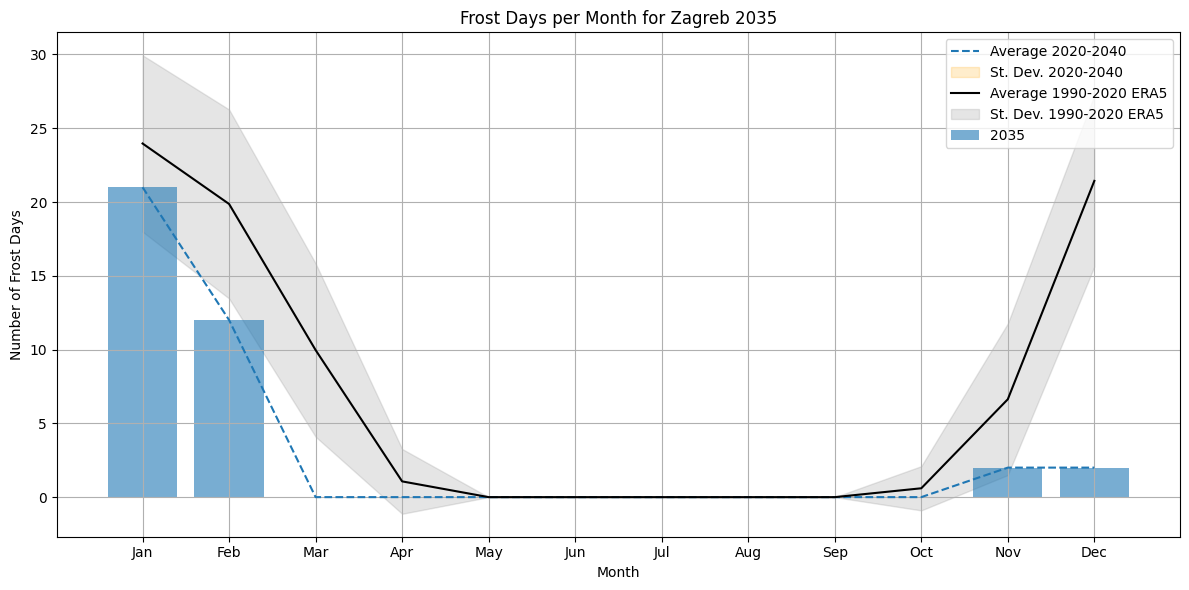

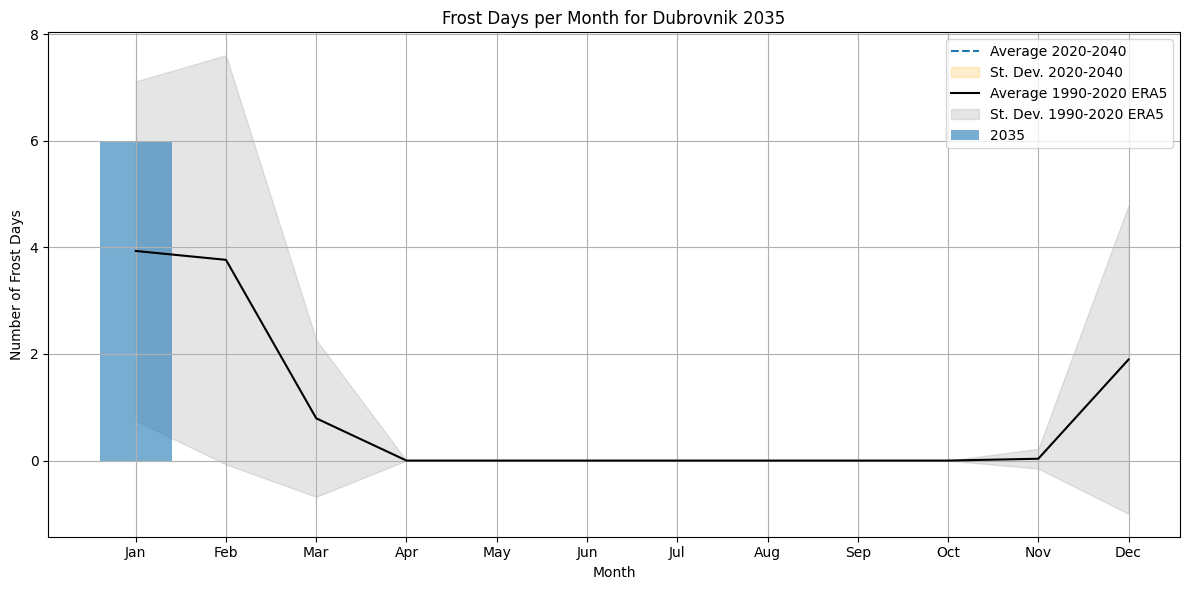

In [18]:
# Select the year 2035 and calculate the number of frost days per month for Zagreb
frost_days_yoi_zagreb = frost_days_per_month_zagreb.loc[str(year_of_interest)]

# Select the year 2035 and calculate the number of frost days per month for dubrovnik
frost_days_yoi_dubrovnik = frost_days_per_month_dubrovnik.loc[str(year_of_interest)]

# Ensure the index is a DatetimeIndex
frost_days_per_month_zagreb.index = pd.to_datetime(frost_days_per_month_zagreb.index)
frost_days_per_month_dubrovnik.index = pd.to_datetime(frost_days_per_month_dubrovnik.index)

# Calculate the average number of frost days per month for the time frame 2020-2025 for Zagreb
frost_days_2020_2025_zagreb = frost_days_per_month_zagreb.loc['2020':'2025']
average_frost_days_2020_2025_zagreb = frost_days_2020_2025_zagreb['t2m'].groupby(frost_days_2020_2025_zagreb.index.month).mean()

# Calculate the average number of frost days per month for the time frame 2020-2040 for Zagreb
frost_days_2020_2040_zagreb = frost_days_per_month_zagreb.loc['2020':'2040']
average_frost_days_2020_2040_zagreb = frost_days_2020_2040_zagreb['t2m'].groupby(frost_days_2020_2040_zagreb.index.month).mean()
std_frost_days_2020_2040_zagreb = frost_days_2020_2040_zagreb['t2m'].groupby(frost_days_2020_2040_zagreb.index.month).std()

# Calculate the average and standard deviation for the whole range of ERA5 data for Zagreb
average_frost_days_era5_zagreb = frost_days_per_month_zagreb_era5['t2m'].groupby(frost_days_per_month_zagreb_era5.index.month).mean()
std_frost_days_era5_zagreb = frost_days_per_month_zagreb_era5['t2m'].groupby(frost_days_per_month_zagreb_era5.index.month).std()

# Calculate the average number of frost days per month for the time frame 2020-2025 for dubrovnik
frost_days_2020_2025_dubrovnik = frost_days_per_month_dubrovnik.loc['2020':'2025']
average_frost_days_2020_2025_dubrovnik = frost_days_2020_2025_dubrovnik['t2m'].groupby(frost_days_2020_2025_dubrovnik.index.month).mean()

# Calculate the average number of frost days per month for the time frame 2020-2040 for dubrovnik
frost_days_2020_2040_dubrovnik = frost_days_per_month_dubrovnik.loc['2020':'2040']
average_frost_days_2020_2040_dubrovnik = frost_days_2020_2040_dubrovnik['t2m'].groupby(frost_days_2020_2040_dubrovnik.index.month).mean()
std_frost_days_2020_2040_dubrovnik = frost_days_2020_2040_dubrovnik['t2m'].groupby(frost_days_2020_2040_dubrovnik.index.month).std()

# Calculate the average and standard deviation for the whole range of ERA5 data for dubrovnik
average_frost_days_era5_dubrovnik = frost_days_per_month_dubrovnik_era5['t2m'].groupby(frost_days_per_month_dubrovnik_era5.index.month).mean()
std_frost_days_era5_dubrovnik = frost_days_per_month_dubrovnik_era5['t2m'].groupby(frost_days_per_month_dubrovnik_era5.index.month).std()

# Plot data for Zagreb and Dubrovnik- Summer Days
frost.plot_data(
    city_name="Zagreb",
    average_data=average_frost_days_2020_2040_zagreb,
    std_data=std_frost_days_2020_2040_zagreb,
    era5_data=average_frost_days_era5_zagreb,
    era5_std=std_frost_days_era5_zagreb,
    year_data=frost_days_yoi_zagreb,
    yoi=year_of_interest,
    plot_type="Frost Days",
    ylabel="Number of Frost Days"
)

frost.plot_data(
    city_name="Dubrovnik",
    average_data=average_frost_days_2020_2040_dubrovnik,
    std_data=std_frost_days_2020_2040_dubrovnik,
    era5_data=average_frost_days_era5_dubrovnik,
    era5_std=std_frost_days_era5_dubrovnik,
    year_data=frost_days_yoi_dubrovnik,
    yoi=year_of_interest,
    plot_type="Frost Days",
    ylabel="Number of Frost Days"
)


<div style="border: 2px solid #909090; background-color: #e1e1e1; padding: 10px; border-radius: 5px;">

As a reference, the following graphs present the results of the full computation (i.e., <i>full_2020_2040_analysis = True</i>), comparing the year 2035 with the entire 2020–2040 range.

<table>
<tr>
    <th><img src="images/frost_output_0.png" width="600"></th>
    <th><img src="images/frost_output_1.png" width="600"></th>
</table>
</div>